In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import cv2
from PIL import Image

class Expand(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample.numpy()
        h, w = image.shape[1], image.shape[2]
        expand_s = self.output_size
        background = np.zeros((1, expand_s, expand_s))
        rnd_x = np.random.randint(expand_s-w, size=1)[0]
        rnd_y = np.random.randint(expand_s-h, size=1)[0]
        background[:,rnd_x:rnd_x+w,rnd_y:rnd_y+h] = image
        return torch.from_numpy(background)

In [3]:
transform_train = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Resize(25),
                 Expand(28),
                 transforms.Normalize((0.5), (0.5))])
transform_test = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5), (0.5))])
classes = []
classes.append(chr(48))
for i in range(65, 91):
    classes.append(chr(i))

In [4]:
batch_size = 26

In [5]:
trainset = torchvision.datasets.EMNIST('data', download=True, train=True, transform=transform_train, split='letters')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [6]:
testset = torchvision.datasets.EMNIST('data', download=True, train=False, transform=transform_train, split='letters')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels)

torch.Size([26, 1, 28, 28])
tensor([19,  3, 14, 20, 16, 24, 18,  7, 24, 22, 17, 13, 12,  4, 26, 19, 17,  5,
        11, 12,  5, 20,  7, 13, 24,  6])


In [8]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    # mirror image and rotate
    npimg = np.fliplr(npimg)
    npimg = np.rot90(npimg, axes=(-1,-2))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(3, 242, 122)


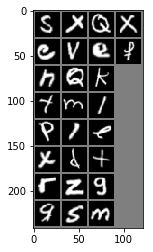

    S     C     N     T     P     X     R     G     X     V     Q     M     L     D     Z     S     Q     E     K     L     E     T     G     M     X     F


In [9]:
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
images[0].size()

torch.Size([1, 28, 28])

In [11]:
len(classes)

27

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 25, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(25, 50, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(50*4*4, 384)
        self.fc2 = nn.Linear(384, 128)
        self.fc3 = nn.Linear(128, 27)
#         self.fc4 = nn.Linear(64, 27)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.size())
        x = x.view(-1, 50*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
        x = self.fc3(x)
        return x

net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/home/laiy/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[1,  4000] loss: 2.659
[2,  4000] loss: 0.705
[3,  4000] loss: 0.543
[4,  4000] loss: 0.467
[5,  4000] loss: 0.425
[6,  4000] loss: 0.394
[7,  4000] loss: 0.375
[8,  4000] loss: 0.356
[9,  4000] loss: 0.338
[10,  4000] loss: 0.323
[11,  4000] loss: 0.313
[12,  4000] loss: 0.302
[13,  4000] loss: 0.294
[14,  4000] loss: 0.288
[15,  4000] loss: 0.278
[16,  4000] loss: 0.270
[17,  4000] loss: 0.264
[18,  4000] loss: 0.260
[19,  4000] loss: 0.251
[20,  4000] loss: 0.249
Finished Training


In [15]:
PATH = './model_letters.pth'
torch.save(net.state_dict(), PATH)

(3, 242, 122)


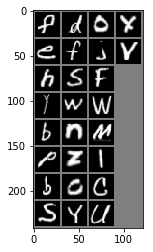

GroundTruth:      F     E     H     Y     B     P     B     S     D     F     S     W     N     Z     O     Y     O     J     F     W     M     L     C     U     X     V


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
outputs = net(images.float())

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

Predicted:      F     E     H     Y     B     P     B     S     D     F     S     W     N     Z     O     Y     O     J     F     W     M     I     C     U     X     V


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


In [21]:
class_len = len(classes)
class_correct = list(0. for i in range(class_len))
class_total = list(0. for i in range(class_len))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
#         for i in range(batch_size):
        for i in range(labels.size()[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(1, class_len):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     A : 95 %
Accuracy of     B : 97 %
Accuracy of     C : 97 %
Accuracy of     D : 94 %
Accuracy of     E : 97 %
Accuracy of     F : 97 %
Accuracy of     G : 77 %
Accuracy of     H : 96 %
Accuracy of     I : 86 %
Accuracy of     J : 95 %
Accuracy of     K : 96 %
Accuracy of     L : 62 %
Accuracy of     M : 98 %
Accuracy of     N : 96 %
Accuracy of     O : 97 %
Accuracy of     P : 98 %
Accuracy of     Q : 89 %
Accuracy of     R : 95 %
Accuracy of     S : 98 %
Accuracy of     T : 98 %
Accuracy of     U : 95 %
Accuracy of     V : 92 %
Accuracy of     W : 98 %
Accuracy of     X : 95 %
Accuracy of     Y : 94 %
Accuracy of     Z : 98 %
